In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("data.csv", parse_dates=True, index_col="Date")
print(df.head())

            Value
Date             
2023-01-11   10.4
2023-01-12   10.6
2023-01-13   10.8
2023-01-14   11.0
2023-01-15   11.2


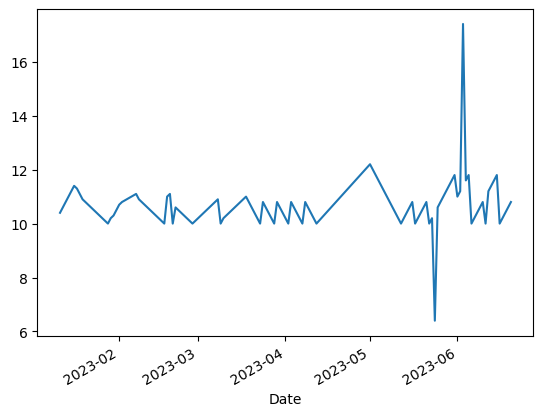

In [3]:
fig, ax = plt.subplots()
df.plot(legend=False, ax=ax)
plt.show()

In [4]:
train = df.loc[df.index <= "2023-04-12 00:00:00"]
test = df.loc[df.index > "2023-04-12 00:00:00"]
train.shape, test.shape

((79, 1), (51, 1))

            Value
Date             
2023-01-11   10.4
2023-01-12   10.6
2023-01-13   10.8
2023-01-14   11.0
2023-01-15   11.2


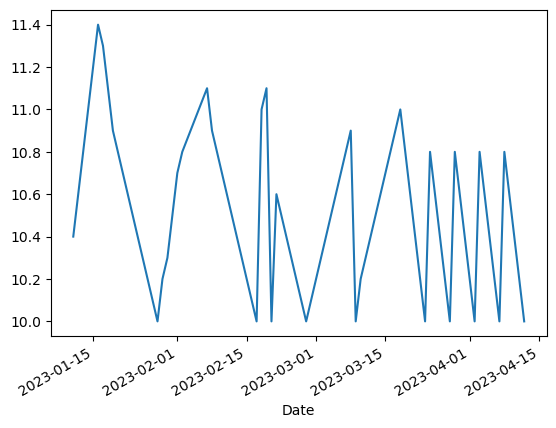

In [5]:
print(train.head())
fig, ax = plt.subplots()
train.plot(legend=False, ax=ax)
plt.show()

            Value
Date             
2023-05-01   12.2
2023-05-02   12.0
2023-05-03   11.8
2023-05-04   11.6
2023-05-05   11.4


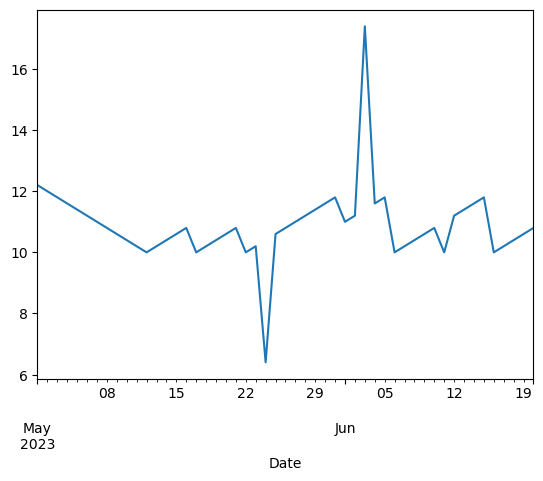

In [6]:
print(test.head())
fig, ax = plt.subplots()
test.plot(legend=False, ax=ax)
plt.show()

In [7]:
training_mean = train.mean()
training_std = train.std()
df_training_value = (train - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 79


In [8]:
TIME_STEPS = 16

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (64, 16, 1)


In [9]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(filters=32, kernel_size=7, padding="same", activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16, kernel_size=7, padding="same", activation="relu"),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=1, kernel_size=7, padding="same", activation="linear"
        ),
    ]
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 32)            256       
                                                                 
 dropout (Dropout)           (None, 16, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 16, 16)           1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 16, 32)           3616      
 ranspose)                                              

In [10]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.9120 - val_loss: 0.7475
Epoch 2/50
1/1 [==============================] - 0s 77ms/step - loss: 0.8863 - val_loss: 0.7252
Epoch 3/50
1/1 [==============================] - 0s 41ms/step - loss: 0.8727 - val_loss: 0.7015
Epoch 4/50
1/1 [==============================] - 0s 45ms/step - loss: 0.8447 - val_loss: 0.6764
Epoch 5/50
1/1 [==============================] - 0s 30ms/step - loss: 0.8207 - val_loss: 0.6489
Epoch 6/50
1/1 [==============================] - 0s 30ms/step - loss: 0.7944 - val_loss: 0.6195
Epoch 7/50
1/1 [==============================] - 0s 29ms/step - loss: 0.7711 - val_loss: 0.5879
Epoch 8/50
1/1 [==============================] - 0s 30ms/step - loss: 0.7402 - val_loss: 0.5540
Epoch 9/50
1/1 [==============================] - 0s 29ms/step - loss: 0.6961 - val_loss: 0.5189
Epoch 10/50
1/1 [==============================] - 0s 30ms/step - loss: 0.6565 - val_loss: 0.4822
Epoch 11/50
1/1 [==============

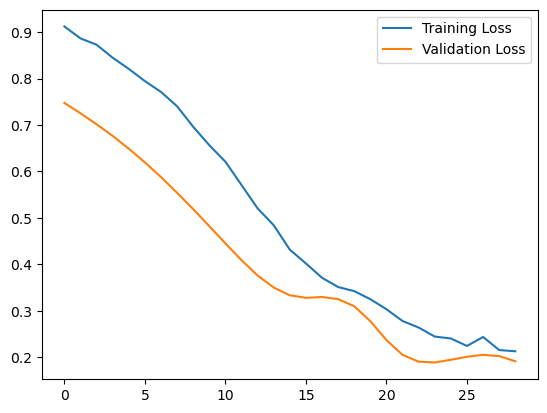

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

2/2 [==============================] - 0s 3ms/step


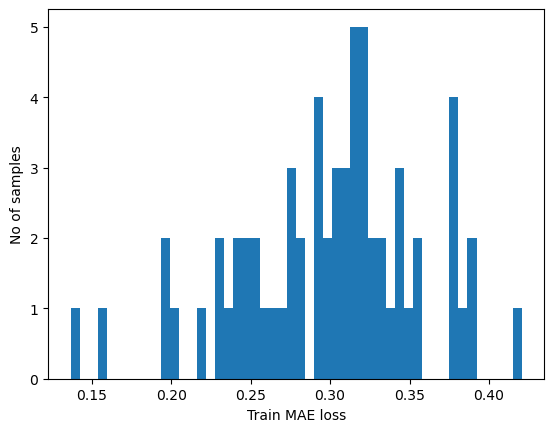

Reconstruction error threshold:  0.4205461787402587


In [12]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

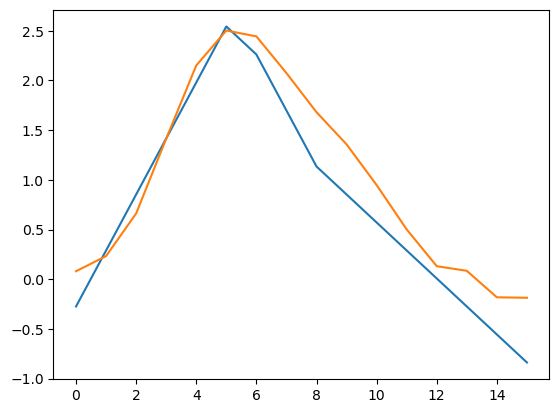

In [13]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

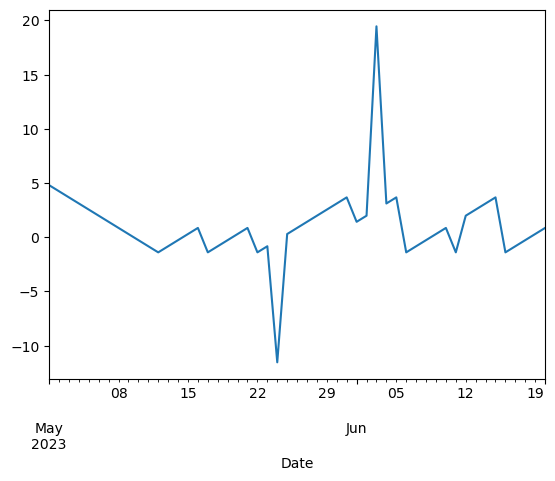

Test input shape:  (36, 16, 1)
2/2 [==============================] - 0s 5ms/step


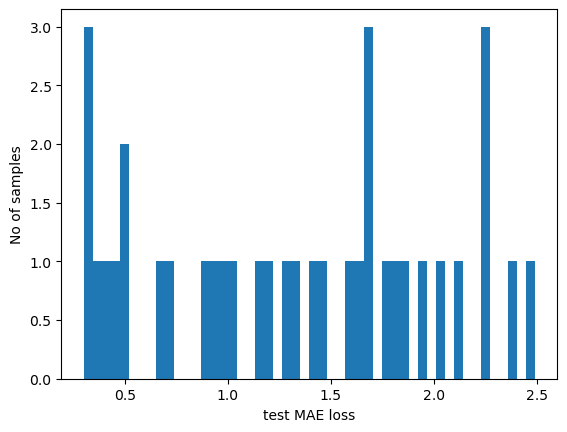

In [14]:
df_test_value = (test - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [15]:
anomalies = test_mae_loss > threshold
anomalies_indices = np.where(anomalies)[0]
anomaly_rows = test.iloc[anomalies_indices]

print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", anomalies_indices)
print(anomaly_rows)

Number of anomaly samples:  31
Indices of anomaly samples:  [ 0  1  2  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35]
            Value
Date             
2023-05-01   12.2
2023-05-02   12.0
2023-05-03   11.8
2023-05-09   10.6
2023-05-10   10.4
2023-05-11   10.2
2023-05-12   10.0
2023-05-13   10.2
2023-05-14   10.4
2023-05-15   10.6
2023-05-16   10.8
2023-05-17   10.0
2023-05-18   10.2
2023-05-19   10.4
2023-05-20   10.6
2023-05-21   10.8
2023-05-22   10.0
2023-05-23   10.2
2023-05-24    6.4
2023-05-25   10.6
2023-05-26   10.8
2023-05-27   11.0
2023-05-28   11.2
2023-05-29   11.4
2023-05-30   11.6
2023-05-31   11.8
2023-06-01   11.0
2023-06-02   11.2
2023-06-03   17.4
2023-06-04   11.6
2023-06-05   11.8


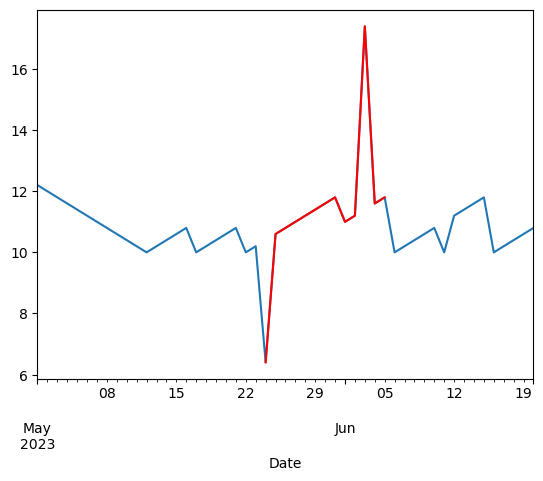

In [16]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

df_subset = test.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()